# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
tmp_name='tmp_old'
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}{tmp_name} # do that to avoid

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp_old': No such file or directory


In [3]:
## Getting dataset
#!mkdir ../../datasets/boing_vs_airbus
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [4]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

sz=299
#arch=resnet34 # F2 :  0.937
arch=resnext50
#arch=resnext101_64
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data augmentation
We randomly change images to allow the model to generalize better.

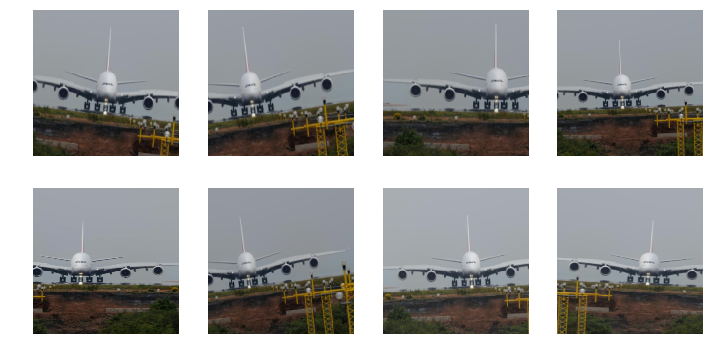

In [5]:

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1,crop_type=CropType.RANDOM)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())

def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

In [6]:
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, tmp_name=tmp_name)
learn.unfreeze()
# resnet34 : acc 93.54%, F2 :  0.93, for learning_rate = 1e-3, dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# Resnext50 : 95.48%, F2 :  0.96, learning_rate = 1e-3, dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# resnext101_64: 93.87 % F2 :  0.95, learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# resnext101_64: F2 :  0.94 (94.51 %)
# After  175  epochs, the accuracy is  94.51 %
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3]
#     [64, 600, 3],
#     [123, 300, 6]
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 6]
#=> With same parameters resnext50 is better than resnet34 and resnext101_64
    
# resnext101_64:  F2 :  0.94 (acc 94.19 %, sometimes 97%) , learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6],
#     [123, 400, 6]
# ]
# After  204  epochs, the accuracy is  94.19 %


# Resnext50 F2 :  0.97 (acc 97.09 %) learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6],
#     [123, 400, 6]
# ]
# After  78  epochs, the accuracy is  96.12 %
# After  141  epochs, the accuracy is  98.06 %
# After  204  epochs, the accuracy is  97.09 %

# F2 :  0.97 (acc 94.51 %) for learning_rate = 1e-3, dropout = [0.25,0.5]
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6]
#After  15  epochs, the accuracy is  91.93 %
#After  78  epochs, the accuracy is  94.83 %
#After  141  epochs, the accuracy is  94.51 %

# XXX test with crop_type=CropType.NO
# for learning_rate = 1e-3, dropout = [0.25,0.5]
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 6]
#After  141  epochs, the accuracy is  95.80 %

# F2 :  0.97 test with crop_type=CropType.NO
#     [512, 64, 4],
#     [256, 128, 6],
#     [123, 300, 7]
#After  205  epochs, the accuracy is  96.77 %

learning_rate = 1e-3
dropout = [0.25,0.5]
global_results = collections.OrderedDict([])
lr = np.array([learning_rate/10,learning_rate/5,learning_rate])
training_loop = [
    [512, 64, 5, lr, CropType.RANDOM, dropout],
    [256, 128, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.NO, [0.25, 0.5, 0.7]],
    [123, 300, 5, lr, CropType.RANDOM, 0.6],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.RANDOM, dropout],
    [123, 300, 5, lr, CropType.NO, 0.3],
]
i = 0
for bs, sz, cycle, lr, crop_type, ps in training_loop:
    i+=1
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5, crop_type=crop_type)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    learn.ps = ps
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True,
                                      best_save_name=arch.__name__ + "-" + str(i) +  "_clean_bestmodel")
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
   
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    print(" with hyperparameters : Batch size=", bs, " Drop out=", ps, " Learning rate=", lr, " Cycle=", cycle, " Images sizes=", sz )
    fichier = "acc" + str(vals_s2s[1]*100)[:5] + '_' + arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)

epoch      trn_loss   val_loss   accuracy                    
    0      0.797304   0.547492   0.71521   
    1      0.543851   0.440182   0.776699                    
    2      0.453605   0.411986   0.799353                    
    3      0.350768   0.353647   0.81877                     
    4      0.333642   0.320246   0.864078                    
    5      0.267982   0.289381   0.877023                    
    6      0.267653   0.273365   0.899676                    
    7      0.23971    0.261017   0.899676                    
    8      0.220846   0.272762   0.886731                    
    9      0.217962   0.223616   0.909385                    
    10     0.15313    0.252459   0.899676                    
    11     0.158492   0.195561   0.915858                    
    12     0.120559   0.191673   0.92233                     
    13     0.131696   0.186778   0.92233                     
    14     0.119204   0.202285   0.92233                     
    15     0.201814   0.16

epoch      trn_loss   val_loss   accuracy                     
    0      0.089604   0.169173   0.935275  
    1      0.092192   0.187455   0.944984                     
    2      0.08591    0.186024   0.938511                     
    3      0.095191   0.176949   0.941748                     
    4      0.097181   0.269729   0.909385                     
    5      0.138154   0.187192   0.935275                     
    6      0.15321    0.21196    0.932039                     
    7      0.106721   0.180111   0.938511                    
    8      0.095342   0.186905   0.932039                     
    9      0.077216   0.179426   0.944984                     
    10     0.066841   0.162586   0.928803                     
    11     0.09573    0.151871   0.928803                     
    12     0.085298   0.151499   0.932039                     
    13     0.15174    0.20669    0.928803                     
    14     0.079906   0.175678   0.935275                     
    15     0

epoch      trn_loss   val_loss   accuracy                     
    0      0.067776   0.199845   0.92233   
    1      0.045396   0.197642   0.932039                     
    2      0.070844   0.158023   0.935275                     
    3      0.07595    0.156807   0.944984                     
    4      0.107007   0.206042   0.925566                     
    5      0.082974   0.143933   0.944984                     
    6      0.082547   0.142628   0.944984                     
    7      0.0767     0.191271   0.919094                     
    8      0.078301   0.181922   0.932039                     
    9      0.042343   0.146657   0.957929                     
    10     0.118224   0.193225   0.928803                     
    11     0.085302   0.159293   0.938511                     
    12     0.065839   0.143531   0.94822                      
    13     0.089788   0.1631     0.944984                     
    14     0.039817   0.150913   0.944984                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.062694   0.157714   0.941748  
    1      0.050138   0.187058   0.925566                     
    2      0.052976   0.146135   0.944984                     
    3      0.057111   0.237665   0.919094                     
    4      0.066361   0.129887   0.964401                     
    5      0.054019   0.132168   0.964401                     
    6      0.072225   0.143754   0.94822                      
    7      0.098711   0.158105   0.938511                     
    8      0.078523   0.201298   0.928803                     
    9      0.070821   0.157635   0.951456                     
    10     0.056539   0.141984   0.957929                     
    11     0.052109   0.132172   0.94822                      
    12     0.061389   0.154779   0.941748                     
    13     0.030815   0.129208   0.951456                     
    14     0.039951   0.123585   0.94822                      
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.049152   0.148171   0.941748  
    1      0.029202   0.173542   0.941748                     
    2      0.08339    0.206788   0.938511                     
    3      0.07521    0.163521   0.944984                     
    4      0.093231   0.183147   0.944984                     
    5      0.058726   0.137366   0.951456                     
    6      0.030421   0.13796    0.954693                     
    7      0.035656   0.134305   0.957929                     
    8      0.046881   0.150498   0.94822                      
    9      0.039898   0.134111   0.961165                     
    10     0.091972   0.152428   0.957929                     
    11     0.036409   0.132266   0.961165                     
    12     0.047852   0.149001   0.954693                     
    13     0.045895   0.135173   0.944984                     
    14     0.03056    0.129007   0.944984                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.025716   0.142633   0.944984  
    1      0.033907   0.164529   0.951456                     
    2      0.046174   0.1517     0.951456                     
    3      0.038914   0.152818   0.954693                     
    4      0.11342    0.124437   0.964401                     
    5      0.054929   0.122964   0.961165                     
    6      0.027133   0.123651   0.957929                     
    7      0.04822    0.135345   0.954693                     
    8      0.062482   0.116092   0.957929                     
    9      0.061788   0.121075   0.961165                     
    10     0.092077   0.183203   0.944984                     
    11     0.035824   0.130818   0.957929                     
    12     0.052355   0.131987   0.957929                     
    13     0.04784    0.123645   0.954693                     
    14     0.064232   0.147159   0.935275                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.023855   0.127102   0.941748  
    1      0.046661   0.12879    0.957929                     
    2      0.132743   0.12333    0.961165                     
    3      0.050869   0.132706   0.957929                     
    4      0.066103   0.156377   0.941748                     
    5      0.069419   0.142995   0.954693                     
    6      0.044824   0.182155   0.928803                     
    7      0.048365   0.157528   0.951456                     
    8      0.049494   0.164872   0.951456                     
    9      0.064795   0.162262   0.94822                      
    10     0.05121    0.112517   0.961165                     
    11     0.041652   0.118102   0.954693                     
    12     0.031647   0.111851   0.954693                     
    13     0.029682   0.119586   0.961165                     
    14     0.036103   0.121788   0.954693                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.069153   0.116326   0.961165  
    1      0.055499   0.112139   0.964401                     
    2      0.054461   0.108946   0.954693                     
    3      0.033892   0.102214   0.967638                     
    4      0.055391   0.109324   0.970874                     
    5      0.041121   0.119195   0.961165                     
    6      0.032719   0.11319    0.967638                     
    7      0.048384   0.134654   0.964401                     
    8      0.033861   0.119185   0.951456                     
    9      0.021938   0.133292   0.957929                     
    10     0.048235   0.133597   0.970874                     
    11     0.032829   0.132563   0.967638                     
    12     0.030148   0.140021   0.964401                     
    13     0.054235   0.184155   0.94822                      
    14     0.040242   0.122392   0.967638                     
    15     

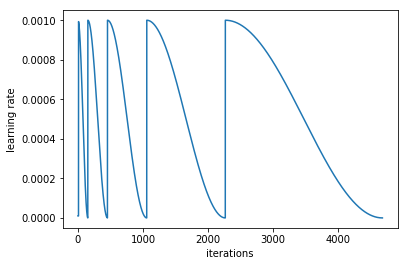

In [7]:
learn.sched.plot_lr()

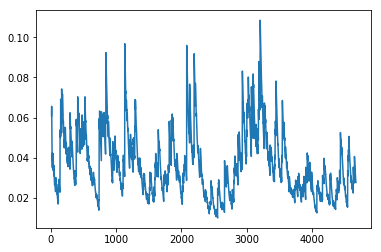

In [8]:
learn.sched.plot_loss()

In [9]:
print("Iterations : ", len(learn.sched.losses))
#ep_vals_s2s.values()
print("Epochs : ", len(global_results))

Iterations :  4681
Epochs :  248


<Figure size 800x640 with 0 Axes>

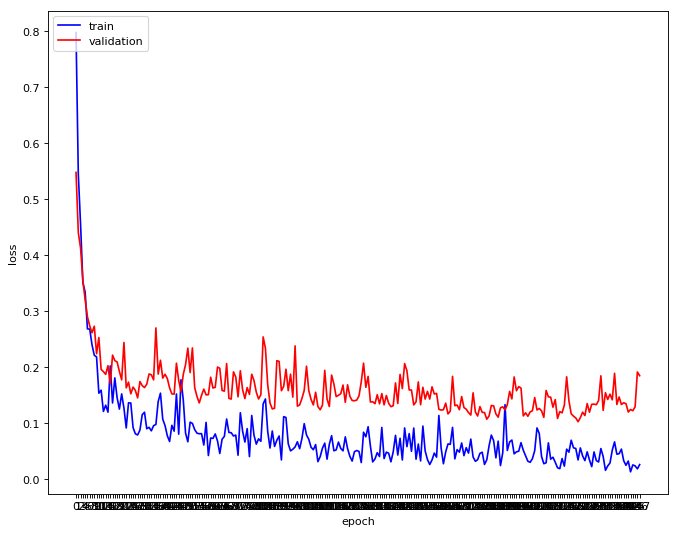

In [10]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
plot_ep_vals(global_results)

## Load the best model

In [11]:

loadmodel=True
if loadmodel==True:
    tfms=tfms_from_model(arch, 300)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
    learn.load("resnext506_bestmodel")
    print("Model loaded.")

Model loaded.


# Prediction et visualisation

0.9644012944983819

[[147   7]
 [  4 151]]


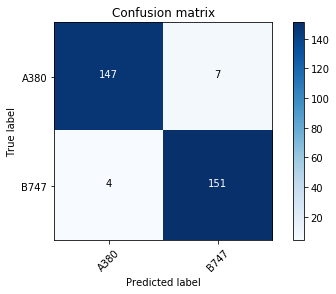

In [12]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [13]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9545454545454546
recall :  0.9735099337748344
F1 :  0.9639344262295083
F2 :  0.9696569920844328


(array([154.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

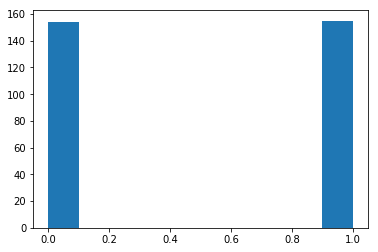

In [14]:
# This is the label for a val data
plt.hist(data.val_y)

In [15]:
# from here we know that 'A380' is label 0 and 'B747' is label 1.
data.classes

['A380', 'B747']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (num of prediction , num of classes)

(309, 2)

In [17]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [18]:
# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 8), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:8]] # Les 32 premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most incorrect A380


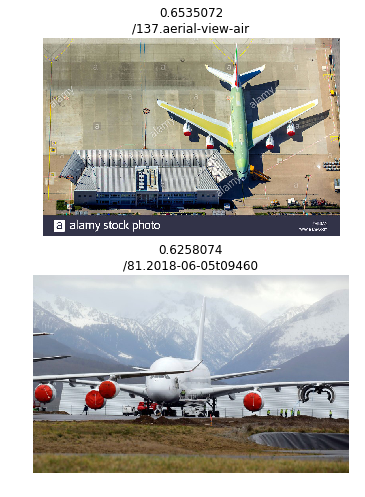

In [19]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect B747


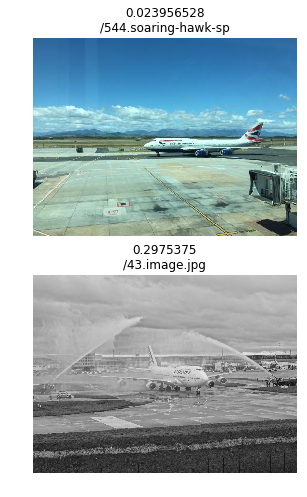

In [20]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


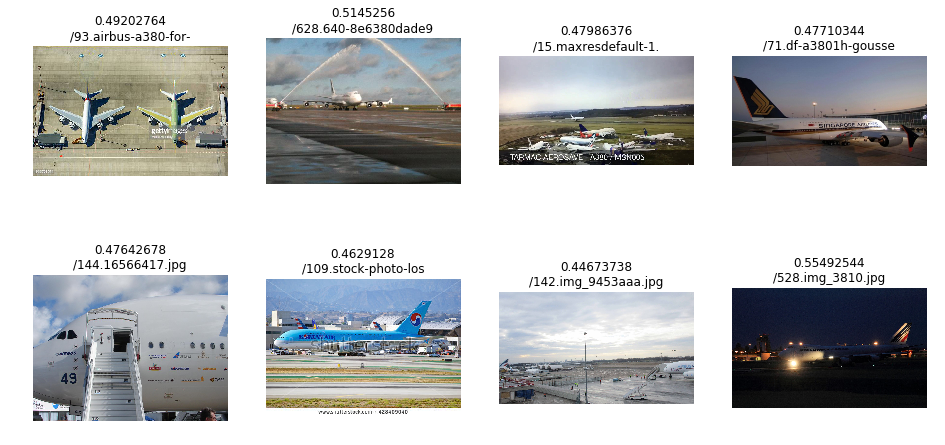

In [21]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:8]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct B747


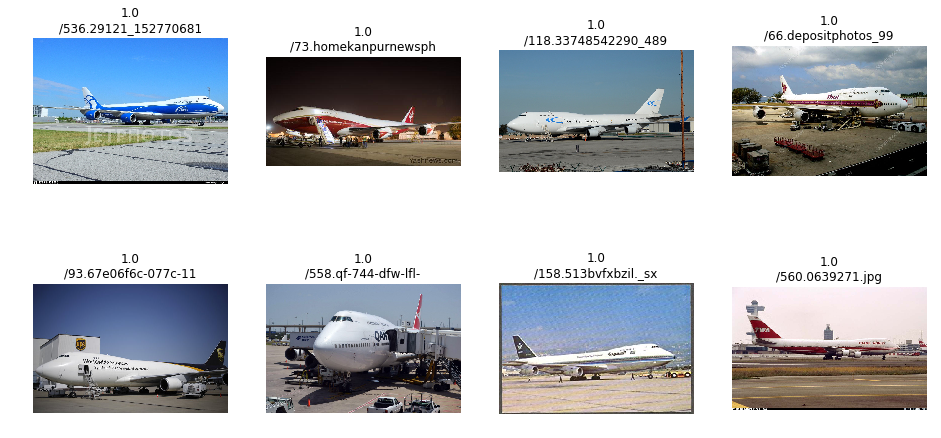

In [22]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct A380


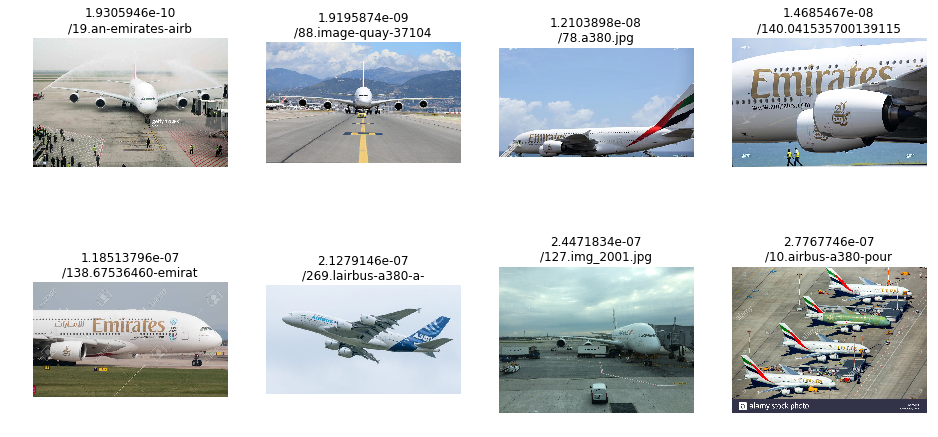

In [23]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])